In [1]:
from qiskit import QuantumCircuit, Aer, execute
from qiskit.visualization import plot_histogram

from math import pi, cos, sin
from numpy import random
from datetime import datetime

In [2]:
def encode_ZX(bits, bases):
    message = []
    for i in range(n):
        qc = QuantumCircuit(1, 1)
        if bases[i] == 0:  # send in Z-basis
            if bits[i] == 0:
                pass  # => |0>
            else:
                qc.x(0)  # => |1>
        else:  # send in X-basis
            if bits[i] == 0:
                qc.h(0)  # => |+>
            else:
                qc.x(0)
                qc.h(0)  # => |->
        qc.barrier()
        message.append(qc)
    return message

In [3]:
def measure_ZX(message, bases):
    backend = Aer.get_backend('qasm_simulator')
    measurements = []
    for i in range(n):
        if bases[i] == 0:  # measure in Z-basis
            message[i].measure(0,0)
        if bases[i] == 1:  # measure in X-basis
            message[i].h(0)
            message[i].measure(0,0)
            message[i].h(0) # resend in X-basis
        result = execute(message[i], backend, shots=1, memory=True).result()
        measured_bit = int(result.get_memory()[0])
        measurements.append(measured_bit)
    return measurements

In [4]:
def remove_garbage(a_bases, b_bases, bits):
    good_bits = []
    for q in range(n):
        if a_bases[q] == b_bases[q]:
            # If both used the same basis, add
            # this to the list of 'good' bits
            good_bits.append(bits[q])
    return good_bits

# Case 1, when there isn't a man in the middle

## Step 1: Alice generates bits and decides to encode them in ZX bases randomly

In [5]:
n = 100

random.seed(seed=int(datetime.now().strftime("%f")))
alice_bits = random.randint(2, size=n)

print("Alice's bits ({}):\n".format(len(alice_bits)), alice_bits)

Alice's bits (100):
 [1 1 1 1 0 0 0 1 1 1 0 1 1 0 0 0 1 1 0 0 0 1 1 0 0 0 1 1 0 0 0 1 1 0 1 0 0
 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 0 1 1 0 0 0 0 1 0 0 0 0 1 1 1 1 1 0 1 0 1
 1 0 1 0 0 0 1 1 1 0 1 1 1 0 1 0 1 1 0 1 0 0 0 0 1 1]


In [6]:
alice_bases = random.randint(2, size=n)
message = encode_ZX(alice_bits, alice_bases)

print("Alice's bases ({}):\n".format(len(alice_bases)), alice_bases)

Alice's bases (100):
 [1 0 1 0 0 1 0 0 1 1 1 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 0
 1 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 0 1 1 0 0 1 0
 1 0 0 1 1 0 0 1 1 0 1 0 1 1 0 0 1 1 0 0 0 0 1 0 1 1]


## ~Step 2: Nope, Eve isn't here.~

## Step 3: Bob was told to measure in ZX bases.

In [7]:
bob_bases = random.randint(2, size=n)
bob_results = measure_ZX(message, bob_bases)

print("Bob's bases ({}):\n".format(len(bob_bases)), bob_bases)

Bob's bases (100):
 [1 1 0 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1
 0 1 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 0 1 1 0 0 1 0 0 0 1 0 1 1 0 0 0 0 0 1 0
 1 0 0 1 0 1 1 1 1 1 1 0 0 0 1 0 0 0 0 1 0 1 1 1 0 0]


## Step 4: After measuring, Bob publishs the array where he used to measure the bits. Alice then publishs hers. They then remove the not-matching bits and the rest is their key.

In [8]:
alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)
bob_key = remove_garbage(alice_bases, bob_bases, bob_results)

print("Alice's key ({}):\n".format(len(alice_key)), alice_key)
print("Bob's key ({}):\n".format(len(bob_key)), bob_key)

Alice's key (46):
 [1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0]
Bob's key (46):
 [1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0]


## Step 5: To double-check, Alice and Bob match half of their key publicly. If there is any difference, they drop the entire key. Else, they have a safe shared key.

In [9]:
match = 0
for i in range(len(bob_key) // 2):
    if bob_key[2 * i] == alice_key[2 * i]:
        match += 1
fit = match / (len(bob_key) // 2)
print("Half of Alice and Bob's keys fit {:.2%}.".format(fit), end=" ")
if fit == 1:
    print("Hence, the chance is high that they are good.")
else:
    print("Hence, there is a man in the middle.")

Half of Alice and Bob's keys fit 100.00%. Hence, the chance is high that they are good.


# Case 2, when Eve is in the middle

## Step 1: Alice generates bits and decides to encode them in ZX bases randomly

In [10]:
n = 100

random.seed(seed=int(datetime.now().strftime("%f")))
alice_bits = random.randint(2, size=n)

print("Alice's bits ({}):\n".format(len(alice_bits)), alice_bits)

Alice's bits (100):
 [0 1 1 1 0 1 0 1 1 0 0 1 0 0 0 0 1 0 0 1 1 0 0 1 1 0 1 0 0 0 1 1 0 0 1 0 1
 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 0 0 0 0 1 0 1 1 0 0
 0 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 0]


In [11]:
alice_bases = random.randint(2, size=n)
message = encode_ZX(alice_bits, alice_bases)

print("Alice's bases ({}):\n".format(len(alice_bases)), alice_bases)

Alice's bases (100):
 [1 1 0 1 0 1 0 1 0 0 0 1 0 0 1 1 1 0 0 1 0 1 1 0 0 1 0 1 0 1 0 0 0 1 0 1 1
 0 1 1 0 0 1 0 1 1 1 1 0 0 1 0 1 0 1 0 1 0 1 0 0 0 0 1 1 0 0 0 1 0 1 1 1 1
 1 0 0 1 0 1 1 0 0 1 1 1 0 0 1 1 0 0 0 1 0 0 1 1 0 1]


## Step 2: Eve heard Alice telling Bob about the ZX bases, and intercepts

In [12]:
eve_bases = random.randint(2, size=n)

print("Eve's bases ({}):\n".format(len(eve_bases)), eve_bases)

Eve's bases (100):
 [0 1 0 0 1 0 1 0 1 0 1 1 1 0 1 1 0 0 0 1 1 1 1 0 1 1 0 1 1 0 1 0 1 0 1 1 1
 0 1 1 0 0 1 1 0 1 1 1 0 0 1 1 0 0 1 1 0 0 1 1 1 0 0 0 0 0 1 1 1 1 1 1 0 1
 1 0 0 0 1 1 0 0 0 1 0 0 1 1 1 1 1 1 1 0 0 0 1 1 0 1]


In [13]:
eve_results = measure_ZX(message, eve_bases)

print("The results Eve reads and resends ({}):\n".format(len(eve_results)), eve_results)

The results Eve reads and resends (100):
 [0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0]


## Step 3: Bob was told to measure in ZX bases.

In [14]:
bob_bases = random.randint(2, size=n)
bob_results = measure_ZX(message, bob_bases)

print("Bob's bases ({}):\n".format(len(bob_bases)), bob_bases)

Bob's bases (100):
 [1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 1 1 1 1 0 1
 1 0 1 1 1 0 1 1 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 1 1 0 1 0 0 1 0 1 0 1
 1 1 1 0 1 0 1 0 1 0 0 0 1 1 0 0 1 0 1 1 0 1 1 1 1 1]


## Step 4: After measuring, Bob publishs the array where he used to measure the bits. Alice then publishs hers. They then remove the not-matching bits and the rest is their key.

In [15]:
alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)
bob_key = remove_garbage(alice_bases, bob_bases, bob_results)

print("Alice's key ({}):\n".format(len(alice_key)), alice_key)
print("Bob's key ({}):\n".format(len(bob_key)), bob_key)

Alice's key (43):
 [0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0]
Bob's key (43):
 [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0]


## Step 5: To double-check, Alice and Bob match half of their key publicly. If there is any difference, they drop the entire key. Else, they have a safe shared key.

In [16]:
match = 0
for i in range(len(bob_key) // 2):
    if bob_key[2 * i] == alice_key[2 * i]:
        match += 1
fit = match / (len(bob_key) // 2)
print("Half of Alice and Bob's keys fit {:.2%}.".format(fit), end=" ")
if fit == 1:
    print("Hence, the chance is high that they are good.")
else:
    print("Hence, there is a man in the middle.")

Half of Alice and Bob's keys fit 71.43%. Hence, there is a man in the middle.


## Step 6: Eve also check and remove the garbage

In [17]:
eve_key = remove_garbage(alice_bases, bob_bases, eve_results)

print("Eve's key ({}):\n".format(len(eve_key)), eve_key)

Eve's key (43):
 [0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0]


In [18]:
match = 0
for i in range(len(eve_key)):
    if eve_key[i] == alice_key[i]:
        match += 1
fit = match / len(eve_key)
print("Alice and Eve's keys fit {:.2%}.".format(fit), end=" ")

Alice and Eve's keys fit 72.09%. 

# (a)

### For each bit, if Eve happens to measure in the same basis as Alice encoded, then Eve would get the correct bit. But if it's not the same basis, Eve still has 1/2 chance to get the correct bit, for Z-basis and X-basis are mutually unbiased bases. Therefore, the probability of Eve guessing Alice’s bit correctly is
$
\frac12 + \frac12 \times \frac12 = \frac34 = 75\% _\#
$.
### We know that if Eve happens to measure in the same basis as Alice encoded, then Eve would get the correct bit. But if it's not the same basis, Eve has 1/2 chance to get the correct bit, and send to Bob in the wrong basis. Still Bob has 1/2 chance to read the bit correctly. Therefore, the probability that Eve has the correct bit and Alice and Bob do not abort the protocol is
$
\frac12 + \frac12 \times \frac12 \times \frac12 = \frac58 = 62.5\% _\#
$.
### As the key length grows, the probability of the above shrinks exponentially. If the key has a length of $m$ bits, the probability would be $(\frac58)^m$. When $m = 10$, it drops to $0.00909\cdots$, lower than $1\%$

# (b)

## First, we calculate the probability of using B-basis to measure the qubits encoded in Z- and X-basis.

0.8535533905932737 0.14644660940672624


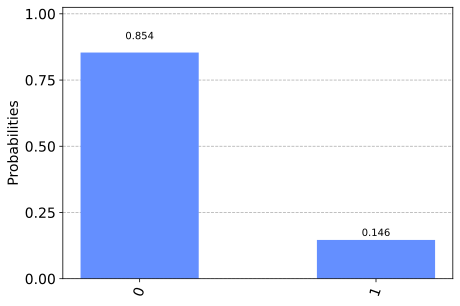

In [19]:
qc = QuantumCircuit(1, 1)
qc.ry(-pi/4, 0)
qc.measure(0, 0)

simulator = Aer.get_backend('qasm_simulator')
job = execute(qc, simulator, shots = 1000000)
result = job.result()
counts = result.get_counts()

print(cos(pi/4 / 2) ** 2, sin(pi/4 / 2) ** 2)
plot_histogram(counts)

0.8535533905932737 0.14644660940672624


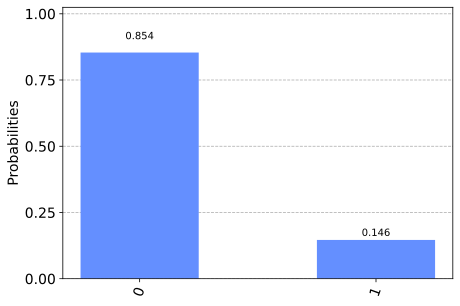

In [20]:
qc = QuantumCircuit(1, 1)
qc.h(0)
qc.ry(-pi/4, 0)
qc.measure(0, 0)

simulator = Aer.get_backend('qasm_simulator')
job = execute(qc, simulator, shots = 1000000)
result = job.result()
counts = result.get_counts()

print(cos(pi/4 / 2) ** 2, sin(pi/4 / 2) ** 2)
plot_histogram(counts)

In [21]:
def measure_BB(message, bases):
    backend = Aer.get_backend('qasm_simulator')
    measurements = []
    for i in range(n):
        message[i].ry(-pi/4, 0)
        message[i].measure(0,0)
        message[i].ry(pi/4, 0) # resend in B-basis
        result = execute(message[i], backend, shots=1, memory=True).result()
        measured_bit = int(result.get_memory()[0])
        measurements.append(measured_bit)
    return measurements

In [22]:
n = 100

random.seed(seed=int(datetime.now().strftime("%f")))
alice_bits = random.randint(2, size=n)

print("Alice's bits ({}):\n".format(len(alice_bits)), alice_bits)

Alice's bits (100):
 [0 1 1 0 1 1 0 0 1 0 0 0 1 0 1 1 1 0 0 1 1 0 0 0 1 1 0 1 1 0 0 0 1 1 0 0 0
 0 0 1 0 1 1 1 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 1 1 0 0 1 0 1 0 1 0 0 0 0 1
 0 1 1 1 0 0 1 0 0 0 0 0 1 0 0 1 0 1 0 1 0 1 0 1 0 1]


In [23]:
alice_bases = random.randint(2, size=n)
message = encode_ZX(alice_bits, alice_bases)

print("Alice's bases ({}):\n".format(len(alice_bases)), alice_bases)

Alice's bases (100):
 [1 0 1 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 1 1 0 0 0 1 1 1 1 0 0 0 0 1 1 1 0 0 0
 1 0 0 0 1 1 1 0 0 0 0 0 1 1 1 1 1 0 1 1 1 0 1 0 1 0 0 1 1 0 0 1 0 1 1 0 1
 1 0 1 1 0 1 1 1 1 1 1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 1]


In [24]:
eve_results = measure_BB(message, [])

print("The results Eve reads and resends ({}):\n".format(len(eve_results)), eve_results)

The results Eve reads and resends (100):
 [0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1]


In [25]:
bob_bases = random.randint(2, size=n)
bob_results = measure_ZX(message, bob_bases)

print("Bob's bases ({}):\n".format(len(bob_bases)), bob_bases)

Bob's bases (100):
 [0 1 1 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 1 1 0 0 1 1 0 0 1 0 1 0 1
 0 1 1 0 0 1 1 1 0 0 1 1 1 0 0 0 0 0 1 1 1 1 1 0 0 0 1 1 0 0 0 0 0 1 0 1 0
 0 0 1 0 1 0 0 0 0 0 1 0 1 1 1 0 1 0 0 1 1 0 1 1 1 0]


In [26]:
alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)
bob_key = remove_garbage(alice_bases, bob_bases, bob_results)

print("Alice's key ({}):\n".format(len(alice_key)), alice_key)
print("Bob's key ({}):\n".format(len(bob_key)), bob_key)

Alice's key (53):
 [1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0]
Bob's key (53):
 [1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0]


In [27]:
match = 0
for i in range(len(bob_key) // 2):
    if bob_key[2 * i] == alice_key[2 * i]:
        match += 1
fit = match / (len(bob_key) // 2)
print("Half of Alice and Bob's keys fit {:.2%}.".format(fit), end=" ")
if fit == 1:
    print("Hence, the chance is high that they are good.")
else:
    print("Hence, there is a man in the middle.")

Half of Alice and Bob's keys fit 88.46%. Hence, there is a man in the middle.


In [28]:
eve_key = remove_garbage(alice_bases, bob_bases, eve_results)

print("Eve's key ({}):\n".format(len(eve_key)), eve_key)

Eve's key (53):
 [1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0]


In [29]:
match = 0
for i in range(len(eve_key)):
    if eve_key[i] == alice_key[i]:
        match += 1
fit = match / len(eve_key)
print("Alice and Eve's keys fit {:.2%}.".format(fit), end=" ")

Alice and Eve's keys fit 86.79%. 

### As the histogram shows, for each bit, Eve has a near 85% chance to get the correct bit. The probability of Eve guessing Alice’s bit correctly is
$
\cos^2(\frac{\pi/4}2) \approx 85.36\% _\# > 75\%
$.
### Since even if Eve gets the correct bit, it will always be resent in another basis, the B. basis. Still Bob has a near 85% chance to read the bit correctly. Therefore, the probability that Eve has the correct bit and Alice and Bob do not abort the protocol is
$
\cos^2(\frac{\pi/4}2) \times \cos^2(\frac{\pi/4}2) \approx 0.7286\% _\# > 62.5\%
$.
### As you can see from both the experiment and the calculation, the probability is a little bit higher when Eve uses the midway basis.